# 🎓 Offline Exam Proctoring System - Complete Integration

## System Architecture:
1. **OpenCV Frame Extraction** → Extract frames from CCTV footage
2. **YOLOv11s-Pose Model** → Detect students and extract keypoints
3. **DeepSORT** → Track individual students with unique IDs
4. **Skeleton ROI Generation** → Create skeleton images from keypoints
5. **ResNet50V2** → Extract 512-d feature embeddings
6. **LSTM** → Temporal analysis of behavior sequences
7. **Decision Module** → Classify as Normal/Suspicious
8. **Output Interface** → Visualize results with bounding boxes

---

## 📦 1. Installation and Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required packages
# REMOVED version constraint on ultralytics to support YOLO11 (C3k2 blocks)
!pip install -U ultralytics
!pip install deep-sort-realtime
!pip install opencv-python-headless
# TensorFlow 2.13 is fine for your Keras models
!pip install tensorflow==2.13.0
!pip install numpy pandas matplotlib seaborn
!pip install scikit-learn
!pip install pillow

print("✅ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 49.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.13.0
✅ All packages installed successfully!


## 📚 2. Import Libraries

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import ultralytics  # Add this import
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, TimeDistributed
from tensorflow.keras.applications import ResNet50V2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import deque, defaultdict
import os
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"Current Ultralytics Version: {ultralytics.__version__}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Libraries imported successfully!
TensorFlow version: 2.19.0
OpenCV version: 4.13.0
Current Ultralytics Version: 8.4.11


## 🦴 3. Skeleton Generation Module

In [ ]:
class SkeletonGenerator:
    """Generate skeleton images from pose keypoints"""
    def __init__(self, img_size=(224, 224)):
        self.img_size = img_size
    def create_skeleton_image(self, keypoints, bbox):
        """
        Create skeleton image from keypoints
        Args:
            keypoints: Array of shape (13, 3) containing [x, y, confidence]
            bbox: Bounding box [x1, y1, x2, y2]
        Returns:
            skeleton_img: RGB skeleton image (224, 224, 3)
        """
        x1, y1, x2, y2 = map(int, bbox)
        width = x2 - x1
        height = y2 - y1
        # Create black canvas
        canvas = np.zeros((height, width, 3), dtype=np.uint8)
        # Adjust keypoints to ROI coordinates
        adjusted_kpts = keypoints.copy()
        adjusted_kpts[:, 0] -= x1  # Adjust x
        adjusted_kpts[:, 1] -= y1  # Adjust y
        # Draw skeleton connections
        for connection in config.SKELETON_CONNECTIONS:
            pt1_idx, pt2_idx = connection
            # Check if both keypoints are visible
            if (adjusted_kpts[pt1_idx][2] > 0.5 and
                adjusted_kpts[pt2_idx][2] > 0.5):
                pt1 = tuple(adjusted_kpts[pt1_idx][:2].astype(int))
                pt2 = tuple(adjusted_kpts[pt2_idx][:2].astype(int))
                # Draw line
                cv2.line(canvas, pt1, pt2, (255, 255, 255), 2)
        # Draw keypoints
        for kpt in adjusted_kpts:
            if kpt[2] > 0.5:  # Confidence threshold
                pt = tuple(kpt[:2].astype(int))
                cv2.circle(canvas, pt, 3, (255, 255, 255), -1)
        # Resize to model input size
        skeleton_img = cv2.resize(canvas, self.img_size)
        return skeleton_img
    def preprocess_for_resnet(self, skeleton_img):
        """Preprocess skeleton image for ResNet50V2"""
        # FIX: Normalize to [-1, 1] for ResNet50V2
        # Original code used [0, 1] which causes distribution shift
        img = skeleton_img.astype(np.float32)
        img = (img - 127.5) / 127.5
        return img
skeleton_generator = SkeletonGenerator()
print("✅ Skeleton generator initialized!")

✅ Skeleton generator initialized!


## ⚙️ 4. Configuration and Parameters

In [ ]:
class Config:
    """System configuration parameters"""

    YOLO_POSE_MODEL = 'yolo11s-pose.pt'


    #System1 Model paths
    RESNET_MODEL_PATH = '/content/drive/MyDrive/First_Training_Outputs/resnet50v2_best.keras'  # Trained ResNet50V2 model1
    LSTM_MODEL_PATH = '/content/drive/MyDrive/First_Training_Outputs/lstm_best.keras'  # Trained LSTM model1

    #System2 Model paths
    #RESNET_MODEL_PATH = '/content/drive/MyDrive/Second_Training_Outputs/resnet50v2_training_results/resnet50v2_best.keras'  # Trained ResNet50V2 model1
    # LSTM_MODEL_PATH = '/content/drive/MyDrive/Second_Training_Outputs/lstm_training_results/lstm_best.keras'  # Trained LSTM model1


    # Image processing
    IMG_SIZE = (224, 224)  # ResNet50V2 input size
    IMG_CHANNELS = 3

    # Sequence parameters
    SEQUENCE_LENGTH = 2
    FEATURE_DIM = 512  # ResNet50V2 embedding dimension

    # Detection parameters
    POSE_CONF_THRESHOLD = 0.5  # YOLOv11s-Pose confidence threshold
    SUSPICIOUS_THRESHOLD = 0.35  # Classification threshold

    # DeepSORT parameters
    MAX_AGE = 30  # Maximum frames to keep track alive
    N_INIT = 3  # Number of frames for track confirmation

    # COCO Keypoints (13 keypoints for YOLOv11s-Pose)
    KEYPOINT_NAMES = [
        'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
        'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist', 'left_hip', 'right_hip'
    ]

    # Skeleton connections for visualization
    SKELETON_CONNECTIONS = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head
        (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),  # Arms
        (5, 11), (6, 12), (11, 12)  # Body
    ]

    # Output parameters
    OUTPUT_DIR = 'output'
    DISPLAY_WIDTH = 1280
    DISPLAY_HEIGHT = 720

config = Config()
print("✅ Configuration loaded!")

✅ Configuration loaded!


## 🤖 4. Load Pre-trained Models

In [ ]:
import torch
import functools
from tensorflow.keras.models import load_model, Model

# --- STEP A: Manual Download ---
if not os.path.exists('yolo11s-pose.pt'):
    print("Downloading yolo11s-pose.pt...")
    !wget https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11s-pose.pt

# --- STEP B: PyTorch 2.6 Security Bypass ---
# This stops the UnpicklingError
torch.load = functools.partial(torch.load, weights_only=False)

# --- STEP C: The Model Loaders ---
def load_yolo_pose_model():
    print(f"Loading YOLO11-Pose...")
    model = YOLO('yolo11s-pose.pt')
    print("✅ YOLO11-Pose (PyTorch) loaded successfully!")
    return model

def load_resnet_feature_extractor():
    """
    Load ResNet50V2 and extract the 512-d feature layer
    """
    print(f"Loading full ResNet model from {config.RESNET_MODEL_PATH}...")
    full_model = load_model(config.RESNET_MODEL_PATH)
    print(f"✅ Full model loaded. Total layers: {len(full_model.layers)}")

    # Print model summary to understand structure
    print("\n=== MODEL ARCHITECTURE ===")
    full_model.summary()

    # Strategy 1: Look for a Dense layer with 512 units
    feature_layer = None
    for layer in full_model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            if layer.units == 512:
                print(f"🎯 Found Dense(512) layer: '{layer.name}'")
                feature_layer = layer
                break

    # Strategy 2: If no Dense(512) found, use the layer before final output
    if feature_layer is None:
        print("⚠️ No Dense(512) found. Using layer before final output...")
        output_layer_name = full_model.layers[-1].name
        output_layer_index = len(full_model.layers) - 1

        # Go backwards to find the previous dense/activation layer
        for i in range(output_layer_index - 1, -1, -1):
            layer = full_model.layers[i]
            # Look for Dense, Activation, or Dropout layers
            if isinstance(layer, (tf.keras.layers.Dense,
                                 tf.keras.layers.Activation,
                                 tf.keras.layers.Dropout)):
                if hasattr(layer, 'units') and layer.units > 1:
                    feature_layer = layer
                    print(f"🎯 Using layer: '{layer.name}' with {layer.units} units")
                    break
            # Also check GlobalAveragePooling
            elif isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
                feature_layer = layer
                print(f"🎯 Using GlobalAveragePooling2D layer: '{layer.name}'")
                break

    # Strategy 3: Fallback - use 'post_relu' if it exists
    if feature_layer is None:
        try:
            feature_layer = full_model.get_layer('post_relu')
            print(f"🎯 Using 'post_relu' layer as fallback")
        except:
            # Last resort - use second to last layer
            feature_layer = full_model.layers[-2]
            print(f"⚠️ Using fallback layer: '{feature_layer.name}'")

    # Create the feature extractor model
    feature_extractor = Model(
        inputs=full_model.input,
        outputs=feature_layer.output,
        name='resnet_feature_extractor'
    )

    # Test the output shape
    test_input = tf.random.normal((1, 224, 224, 3))
    test_output = feature_extractor(test_input)

    print(f"\n✅ Feature Extractor Created!")
    print(f"   Input shape:  {feature_extractor.input_shape}")
    print(f"   Output shape: {feature_extractor.output_shape}")
    print(f"   Feature dimension: {test_output.shape[-1]}")

    # Verify the dimension is 512 or update config
    actual_dim = test_output.shape[-1]
    if actual_dim != 512:
        print(f"\n⚠️ WARNING: Expected 512-d features, got {actual_dim}-d")
        print(f"   Updating config.FEATURE_DIM to {actual_dim}")
        config.FEATURE_DIM = actual_dim
    else:
        print(f"\n✅ Perfect! 512-d feature embeddings confirmed.")

    return feature_extractor


def load_lstm_classifier():
    print(f"Loading LSTM from {config.LSTM_MODEL_PATH}...")
    if os.path.exists(config.LSTM_MODEL_PATH):
        model = load_model(config.LSTM_MODEL_PATH)
        print("✅ Fine-tuned LSTM (Keras) loaded!")
        print(f"   Expected input shape: {model.input_shape}")
        print(f"   Output shape: {model.output_shape}")
        return model
    else:
        raise FileNotFoundError(f"❌ LSTM model not found at {config.LSTM_MODEL_PATH}")


# --- Load all models ---
print("\n" + "="*60)
print("🚀 LOADING ALL MODELS")
print("="*60 + "\n")

yolo_model = load_yolo_pose_model()
resnet_model = load_resnet_feature_extractor()
lstm_model = load_lstm_classifier()

print("\n" + "="*60)
print("✅ ALL MODELS LOADED SUCCESSFULLY!")
print("="*60)


🚀 LOADING ALL MODELS

Loading YOLO11-Pose...
✅ YOLO11-Pose (PyTorch) loaded successfully!
Loading full ResNet model from /content/drive/MyDrive/First_Training_Outputs/resnet50v2_best.keras...
✅ Full model loaded. Total layers: 194

=== MODEL ARCHITECTURE ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 26,713,605 (101.90 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 2,099,204 (8.01 MB)

🎯 Found Dense(512) layer: 'embedding'

✅ Feature Extractor Created!
   Input shape:  (None, 224, 224, 3)
   Output shape: (None, 512)
   Feature dimension: 512

✅ Perfect! 512-d feature embeddings confirmed.
Loading LSTM from /content/drive/MyDrive/First_Training_Outputs/lstm_best.keras...
✅ Fine-tuned LSTM (Keras) loaded!
   Expected input shape: (None, 10, 512)
   Output shape: (None, 1)

✅ ALL MODELS LOADED SUCCESSFULLY!


## 🦴 5. Skeleton Generation Module

## 🎯 6. Student Tracking Module

In [ ]:
import numpy as np
from collections import deque, defaultdict
from deep_sort_realtime.deepsort_tracker import DeepSort

class StudentTracker:
    """Track individual students using DeepSORT and manage temporal features"""

    def __init__(self):
        self.tracker = DeepSort(
            max_age=config.MAX_AGE,
            n_init=config.N_INIT,
            max_iou_distance=0.7,
            max_cosine_distance=0.3,
            nn_budget=100
        )

        # Buffer for 512-d feature sequences
        self.student_sequences = defaultdict(lambda: deque(maxlen=config.SEQUENCE_LENGTH))
        self.student_predictions = {}
        self.student_colors = {}

    def update(self, detections, frame):
        detection_list = []
        for bbox, conf, _ in detections:
            x1, y1, x2, y2 = bbox
            detection_list.append(([x1, y1, x2-x1, y2-y1], conf, "student"))

        return self.tracker.update_tracks(detection_list, frame=frame)

    def add_feature(self, student_id, feature):
        # Force flatten and verify size
        feat = np.array(feature).flatten()
        if feat.shape[0] == 512:
            self.student_sequences[student_id].append(feat)
        else:
            # Handle cases where ResNet might output different shapes
            print(f"Warning: Expected 512 features, got {feat.shape[0]}")

    def get_sequence(self, student_id):
        return np.array(list(self.student_sequences[student_id]))

    def is_sequence_ready(self, student_id):
        return len(self.student_sequences[student_id]) == config.SEQUENCE_LENGTH

    def set_prediction(self, student_id, prediction, confidence):
        self.student_predictions[student_id] = {'class': prediction, 'confidence': confidence}
        self.student_colors[student_id] = (0, 0, 255) if prediction == 'Suspicious' else (0, 255, 0)

    def get_color(self, student_id):
        return self.student_colors.get(student_id, (0, 255, 255))

## 🔄 7. Main Processing Pipeline

In [ ]:
import numpy as np
import cv2

class ExamProctoringPipeline:
    """Main processing pipeline integrating YOLO, DeepSORT, ResNet, and LSTM"""

    def __init__(self, yolo_model, resnet_model, lstm_model, tracker, skeleton_gen):
        self.yolo_model = yolo_model
        self.resnet_model = resnet_model
        self.lstm_model = lstm_model
        self.tracker = tracker
        self.skeleton_gen = skeleton_gen

        # Statistics
        self.frame_count = 0
        self.suspicious_count = 0

    def _calculate_iou(self, boxA, boxB):
        """Helper to match tracks with detections spatially"""
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        return interArea / float(boxAArea + boxBArea - interArea)

    def process_frame(self, frame):
        """Process a single frame through the complete pipeline"""
        self.frame_count += 1
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Step 1: YOLOv11s-Pose Detection
        results = self.yolo_model(rgb_frame, conf=config.POSE_CONF_THRESHOLD, verbose=False)

        detections = []
        if results[0].keypoints is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            confidences = results[0].boxes.conf.cpu().numpy()
            keypoints = results[0].keypoints.data.cpu().numpy()
            for bbox, conf, kpts in zip(boxes, confidences, keypoints):
                detections.append((bbox, conf, kpts))

        # Step 2: DeepSORT Tracking (Update)
        tracks = self.tracker.update(detections, frame)
        detections_info = []

        # Step 3: Process each tracked student
        for track in tracks:
            if not track.is_confirmed():
                continue

            track_id = track.track_id
            track_bbox = track.to_ltrb() # [x1, y1, x2, y2]

            # --- Logic to find the correct keypoints for this Track ID ---
            best_match_idx = -1
            max_iou = 0.3 # Minimum threshold to consider a match

            for idx, (d_bbox, d_conf, d_kpts) in enumerate(detections):
                iou = self._calculate_iou(track_bbox, d_bbox)
                if iou > max_iou:
                    max_iou = iou
                    best_match_idx = idx

            # If we can't find the keypoints for this student in this frame, skip
            if best_match_idx == -1:
                continue

            kpts = detections[best_match_idx][2]
            current_bbox = detections[best_match_idx][0]

            # Step 4: Generate Skeleton ROI
            skeleton_img = self.skeleton_gen.create_skeleton_image(kpts, current_bbox)
            skeleton_preprocessed = self.skeleton_gen.preprocess_for_resnet(skeleton_img)

            # Step 5: Extract Features with ResNet50V2 (Output should be 512-dim)
            features = self.resnet_model.predict(
                np.expand_dims(skeleton_preprocessed, axis=0),
                verbose=0
            )
            features = features.flatten() # Ensure (512,)

            # Step 6: Add to temporal sequence
            self.tracker.add_feature(track_id, features)

            # Step 7: LSTM Classification
            prediction_text = "Analyzing..."
            confidence = 0.0

            if self.tracker.is_sequence_ready(track_id):
                sequence = np.array(self.tracker.get_sequence(track_id))

                # Reshape to (1, 16, 512)
                sequence = sequence.reshape(1, config.SEQUENCE_LENGTH, 512)

                # Predict - FIXED: LSTM outputs (1, 1), not (1, 2)
                prediction = self.lstm_model.predict(sequence, verbose=0)[0][0]
                suspicious_score = prediction

                # Decision
                if suspicious_score > config.SUSPICIOUS_THRESHOLD:
                    pred_class = "Suspicious"
                    self.suspicious_count += 1
                else:
                    pred_class = "Normal"

                confidence = suspicious_score
                self.tracker.set_prediction(track_id, pred_class, confidence)
                prediction_text = f"{pred_class} ({confidence:.2f})"

            # --- Drawing Logic ---
            color = self.tracker.get_color(track_id)
            x1, y1, x2, y2 = map(int, track_bbox)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            label = f"Student_{track_id}: {prediction_text}"
            cv2.putText(frame, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            detections_info.append({
                'student_id': track_id,
                'bbox': track_bbox.tolist(),
                'prediction': prediction_text
            })

        return frame, detections_info

# Final Reset and Initialization
student_tracker = StudentTracker()
pipeline = ExamProctoringPipeline(
    yolo_model=yolo_model,
    resnet_model=resnet_model,
    lstm_model=lstm_model,
    tracker=student_tracker,
    skeleton_gen=skeleton_generator
)

print("🚀 Pipeline fully updated and ready for processing!")

🚀 Pipeline fully updated and ready for processing!


#Test Feature Extraction

In [ ]:
# Debug Cell - Test feature extraction
import numpy as np

# Create dummy skeleton image
test_skeleton = np.random.rand(224, 224, 3).astype(np.float32)

# Extract features
test_features = resnet_model.predict(np.expand_dims(test_skeleton, axis=0), verbose=0)[0]
test_features = test_features.flatten()

print(f"✅ Feature shape: {test_features.shape}")
print(f"✅ Feature type: {type(test_features)}")
print(f"✅ Feature size: {test_features.size}")

# Test sequence building (use config.SEQUENCE_LENGTH instead of hardcoded 30)
test_tracker = StudentTracker()
for i in range(config.SEQUENCE_LENGTH):
    test_tracker.add_feature(999, test_features)

test_seq = np.array(test_tracker.get_sequence(999))
print(f"\n✅ Sequence shape: {test_seq.shape}")
print(f"✅ Expected: ({config.SEQUENCE_LENGTH}, 512)")

# Test reshape (use config.SEQUENCE_LENGTH)
test_seq_reshaped = test_seq.reshape(1, config.SEQUENCE_LENGTH, 512)
print(f"✅ Reshaped shape: {test_seq_reshaped.shape}")
print(f"✅ Expected: (1, {config.SEQUENCE_LENGTH}, 512)")

print("\n✅ All tests passed! Ready to process video.")

✅ Feature shape: (512,)
✅ Feature type: <class 'numpy.ndarray'>
✅ Feature size: 512

✅ Sequence shape: (2, 512)
✅ Expected: (2, 512)
✅ Reshaped shape: (1, 2, 512)
✅ Expected: (1, 2, 512)

✅ All tests passed! Ready to process video.


## 🎬 8. Video Processing Functions

In [ ]:
def process_video(video_path, output_path=None, display=True, frame_skip=1):
    """
    Process video file through the exam proctoring pipeline
    Args:
        video_path: Path to input video
        output_path: Path to save output video (optional)
        display: Whether to display processing (for Colab)
        frame_skip: Process every nth frame (default 1)
    Returns:
        results_summary: Dictionary with processing statistics
    """
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Could not open video {video_path}")
        return None
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"\\n📹 Video Info:")
    print(f"   Resolution: {width}x{height}")
    print(f"   FPS: {fps}")
    print(f"   Total Frames: {total_frames}")
    print(f"   Duration: {total_frames/fps:.2f} seconds\\n")
    # Setup output video writer
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        # FIX: Adjust output FPS to match the processing speed (skipping frames)
        out_fps = fps / frame_skip
        out = cv2.VideoWriter(output_path, fourcc, out_fps, (width, height))
    # Processing loop
    frame_num = 0
    all_detections = []
    try:
        from tqdm.notebook import tqdm
        pbar = tqdm(total=total_frames, desc="Processing frames")
    except:
        pbar = None
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Skip frames if needed
        if frame_num % frame_skip != 0:
            frame_num += 1
            if pbar:
                pbar.update(1)
            continue
        # Process frame
        processed_frame, detections = pipeline.process_frame(frame)
        all_detections.extend(detections)
        # Write to output
        if output_path:
            out.write(processed_frame)
        frame_num += 1
        if pbar:
            pbar.update(1)
        # Optional: Display every nth frame in Colab
        if display and frame_num % 30 == 0:
            from IPython.display import clear_output
            clear_output(wait=True)
            plt.figure(figsize=(12, 8))
            plt.imshow(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Frame {frame_num}/{total_frames}")
            plt.show()
    if pbar:
        pbar.close()
    # Clean up
    cap.release()
    if output_path:
        out.release()
    # Generate summary
    results_summary = {
        'total_frames': frame_num,
        'total_detections': len(all_detections),
        'suspicious_incidents': pipeline.suspicious_count,
        'output_path': output_path
    }
    print("\\n✅ Processing complete!")
    print(f"   Total frames processed: {frame_num}")
    print(f"   Total detections: {len(all_detections)}")
    print(f"   Suspicious incidents: {pipeline.suspicious_count}")
    return results_summary
def process_webcam(duration_seconds=60):
    """
    Process webcam feed in real-time
    Args:
        duration_seconds: How long to process (default 60 seconds)
    """
    print("⚠️ Note: Webcam processing in Colab requires browser permissions")
    print("For best results, upload a video file instead.\\n")
    # This is a placeholder - actual webcam in Colab requires JavaScript
    print("Please use the process_video() function with an uploaded video file.")
print("✅ Video processing functions defined!")

✅ Video processing functions defined!


## 📤 9. Upload and Process Video

In [ ]:
# Option 1: Upload video file from local computer
print("Please upload your exam video file:")
uploaded = files.upload()

# Get the uploaded filename
video_filename = list(uploaded.keys())[0]
print(f"\n✅ Video uploaded: {video_filename}")

Please upload your exam video file:


Saving VID_20260203_155349.mp4 to VID_20260203_155349.mp4

✅ Video uploaded: VID_20260203_155349.mp4


In [ ]:
# Clear the 'dirty' memory
student_tracker = StudentTracker()

# Re-initialize the pipeline with the fresh tracker
pipeline = ExamProctoringPipeline(
    yolo_model=yolo_model,
    resnet_model=resnet_model,
    lstm_model=lstm_model,
    tracker=student_tracker,
    skeleton_gen=skeleton_generator
)

print("🧹 Tracker memory cleared and Pipeline reset! You can now run the video.")

🧹 Tracker memory cleared and Pipeline reset! You can now run the video.


In [ ]:
# Option 2: Or specify video path if already in Colab/Drive
# video_filename = "/content/drive/MyDrive/exam_video.mp4"

# Create output directory
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

# Process the video
output_video_path = os.path.join(config.OUTPUT_DIR, 'processed_' + video_filename)

# SPEED UP: Process every 3rd frame
results = process_video(
    video_path=video_filename,
    output_path=output_video_path,
    display=True,
    frame_skip=15  # Process every 5th frame
)

print(f"\n✅ Output saved to: {output_video_path}")

\n📹 Video Info:
   Resolution: 1280x720
   FPS: 30
   Total Frames: 1793
   Duration: 59.77 seconds\n


Processing frames:   0%|          | 0/1793 [00:00<?, ?it/s]

\n✅ Processing complete!
   Total frames processed: 1793
   Total detections: 471
   Suspicious incidents: 0

✅ Output saved to: output/processed_VID_20260203_155349.mp4


## 💾 10. Download Processed Video

In [ ]:
# Download processed video
if os.path.exists(output_video_path):
    files.download(output_video_path)
    print("✅ Download started!")
else:
    print("❌ Output file not found!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download started!


## 📊 11. Results Analysis and Visualization


📊 EXAM PROCTORING ANALYSIS REPORT

📹 Video Processing Summary:
   Total Frames Processed: 1793
   Total Student Detections: 471
   Suspicious Incidents Detected: 0
   Suspicion Rate: 0.00%

💾 Output:
   Processed video saved to: output/processed_VID_20260203_155349.mp4



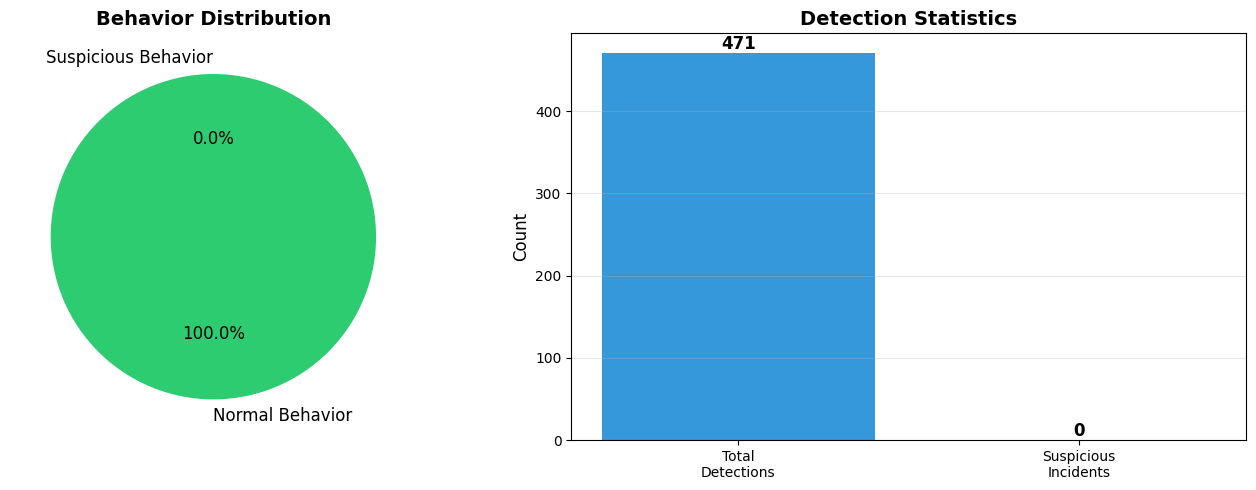


✅ Analysis report generated!


In [ ]:
def generate_analysis_report(results):
    """
    Generate comprehensive analysis report
    """
    print("\n" + "="*60)
    print("📊 EXAM PROCTORING ANALYSIS REPORT")
    print("="*60)

    print(f"\n📹 Video Processing Summary:")
    print(f"   Total Frames Processed: {results['total_frames']}")
    print(f"   Total Student Detections: {results['total_detections']}")
    print(f"   Suspicious Incidents Detected: {results['suspicious_incidents']}")

    if results['total_detections'] > 0:
        suspicion_rate = (results['suspicious_incidents'] / results['total_detections']) * 100
        print(f"   Suspicion Rate: {suspicion_rate:.2f}%")

    print(f"\n💾 Output:")
    print(f"   Processed video saved to: {results['output_path']}")

    print("\n" + "="*60)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Pie chart
    normal_count = results['total_detections'] - results['suspicious_incidents']
    labels = ['Normal Behavior', 'Suspicious Behavior']
    sizes = [normal_count, results['suspicious_incidents']]
    colors = ['#2ecc71', '#e74c3c']

    axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                startangle=90, textprops={'fontsize': 12})
    axes[0].set_title('Behavior Distribution', fontsize=14, fontweight='bold')

    # Bar chart
    categories = ['Total\nDetections', 'Suspicious\nIncidents']
    values = [results['total_detections'], results['suspicious_incidents']]
    bars = axes[1].bar(categories, values, color=['#3498db', '#e74c3c'])
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title('Detection Statistics', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'analysis_report.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Analysis report generated!")

# Generate report
if results:
    generate_analysis_report(results)

## 🛠️ 12. Utility Functions

In [ ]:
def save_models():
    """Save trained models"""
    print("Saving models...")

    if resnet_model:
        resnet_model.save(config.RESNET_MODEL_PATH)
        print(f"✅ ResNet model saved to {config.RESNET_MODEL_PATH}")

    if lstm_model:
        lstm_model.save(config.LSTM_MODEL_PATH)
        print(f"✅ LSTM model saved to {config.LSTM_MODEL_PATH}")

def upload_trained_models():
    """Upload pre-trained model files"""
    print("Please upload your trained model files:")
    print("Expected files: resnet50v2_model.h5, lstm_model.h5")

    uploaded_models = files.upload()

    for filename in uploaded_models.keys():
        print(f"✅ Uploaded: {filename}")

    return uploaded_models

def extract_sample_frames(video_path, num_frames=5):
    """
    Extract sample frames from video for preview
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    cap.release()

    # Display frames
    fig, axes = plt.subplots(1, num_frames, figsize=(20, 4))
    for i, (frame, ax) in enumerate(zip(frames, axes)):
        ax.imshow(frame)
        ax.axis('off')
        ax.set_title(f"Frame {frame_indices[i]}")
    plt.tight_layout()
    plt.show()

def test_single_frame(frame_path):
    """
    Test pipeline on a single frame
    """
    frame = cv2.imread(frame_path)
    if frame is None:
        print("❌ Could not load image")
        return

    processed, detections = pipeline.process_frame(frame)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Processed Frame')
    plt.show()

    print(f"\nDetections: {len(detections)}")
    for det in detections:
        print(f"  Student {det['student_id']}: {det['prediction']}")

print("✅ Utility functions defined!")

✅ Utility functions defined!


## 📁 13. Optional: Mount Google Drive

In [ ]:
# Mount Google Drive to access videos and save outputs
from google.colab import drive
drive.mount('/content/drive')

print("\n✅ Google Drive mounted!")
print("You can now access files from: /content/drive/MyDrive/")

## 🔄 14. Batch Processing Multiple Videos

In [ ]:
def batch_process_videos(video_folder, output_folder=None):
    """
    Process multiple videos in a folder

    Args:
        video_folder: Path to folder containing videos
        output_folder: Path to save processed videos
    """
    if output_folder is None:
        output_folder = os.path.join(video_folder, 'processed')

    os.makedirs(output_folder, exist_ok=True)

    # Find all video files
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv']
    video_files = []

    for ext in video_extensions:
        video_files.extend(Path(video_folder).glob(f'*{ext}'))

    print(f"Found {len(video_files)} videos to process\n")

    all_results = []

    for i, video_path in enumerate(video_files, 1):
        print(f"\n{'='*60}")
        print(f"Processing video {i}/{len(video_files)}: {video_path.name}")
        print(f"{'='*60}")

        output_path = os.path.join(output_folder, f'processed_{video_path.name}')

        result = process_video(
            video_path=str(video_path),
            output_path=output_path,
            display=False
        )

        if result:
            result['video_name'] = video_path.name
            all_results.append(result)

    # Generate batch summary
    print(f"\n\n{'='*60}")
    print("📊 BATCH PROCESSING SUMMARY")
    print(f"{'='*60}\n")

    for result in all_results:
        print(f"Video: {result['video_name']}")
        print(f"  Frames: {result['total_frames']}")
        print(f"  Detections: {result['total_detections']}")
        print(f"  Suspicious: {result['suspicious_incidents']}")
        print()

    return all_results

# Example usage:
# results = batch_process_videos('/content/drive/MyDrive/exam_videos')

print("✅ Batch processing function defined!")

## 📤 15. Export Detection Logs

In [ ]:
import json
import pandas as pd
from datetime import datetime

def export_detection_logs(detections_list, output_format='csv'):
    """
    Export detection logs to CSV or JSON

    Args:
        detections_list: List of detection dictionaries
        output_format: 'csv' or 'json'
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    if output_format == 'csv':
        df = pd.DataFrame(detections_list)
        filename = f'detection_log_{timestamp}.csv'
        df.to_csv(filename, index=False)
        print(f"✅ CSV log saved: {filename}")
        files.download(filename)

    elif output_format == 'json':
        filename = f'detection_log_{timestamp}.json'
        with open(filename, 'w') as f:
            json.dump(detections_list, f, indent=2)
        print(f"✅ JSON log saved: {filename}")
        files.download(filename)

print("✅ Export functions defined!")

✅ Export functions defined!


## 📖 16. System Usage Guide

### Quick Start Guide:

#### 1. **First Time Setup:**
```python
# Run all cells from top to bottom
# Upload your trained models when prompted:
upload_trained_models()
```

#### 2. **Process a Single Video:**
```python
# Upload video
uploaded = files.upload()
video_file = list(uploaded.keys())[0]

# Process
results = process_video(
    video_path=video_file,
    output_path='processed_output.mp4',
    display=True
)

# Download result
files.download('processed_output.mp4')
```

#### 3. **Process from Google Drive:**
```python
# Mount Drive
drive.mount('/content/drive')

# Process video from Drive
results = process_video(
    video_path='/content/drive/MyDrive/exam_video.mp4',
    output_path='/content/drive/MyDrive/processed_exam.mp4'
)
```

#### 4. **Batch Process Multiple Videos:**
```python
results = batch_process_videos(
    video_folder='/content/drive/MyDrive/exam_videos',
    output_folder='/content/drive/MyDrive/processed_videos'
)
```

### System Components:

- **YOLOv11s-Pose**: Detects students and extracts 13 keypoints
- **DeepSORT**: Tracks individual students across frames
- **Skeleton Generator**: Creates 224x224 skeleton images
- **ResNet50V2**: Extracts 512-dimensional features
- **LSTM**: Analyzes temporal sequences (30 frames)
- **Decision Module**: Classifies behavior (threshold: 0.35)

### Output:

- **Green Box**: Normal behavior
- **Red Box**: Suspicious behavior
- **Yellow Box**: Analyzing (sequence not ready)

### Performance Tips:

1. Use GPU runtime: Runtime → Change runtime type → GPU
2. Process videos at original resolution for best results
3. For long videos, consider processing in batches
4. Save outputs to Google Drive to avoid data loss

---

## ✅ System Ready!

Your exam proctoring system is now fully configured and ready to use.

### Next Steps:
1. Upload your trained ResNet50V2 and LSTM models (or the system will use default ImageNet weights)
2. Upload a test video or mount Google Drive
3. Run the processing pipeline
4. Download and review results

### Support:
- Ensure YOLOv11s-Pose model is downloaded
- GPU acceleration recommended for faster processing
- Check output folder for processed videos and logs

**Happy Proctoring!**